In [1]:
from tkinter import *
from tkinter import filedialog
from scapy.all import *
from collections import defaultdict
import csv
from tkinter import ttk
import subprocess
from datetime import datetime
import smtplib as s
import bcrypt
import getpass
import pandas as pd
from scapy.layers.inet import IP, TCP, UDP
import matplotlib.pyplot as plt
import seaborn as sns

import time

# Alert System

In [2]:
!pip install bcrypt
!pip install scapy

In [3]:
from datetime import datetime
import smtplib as s
import bcrypt
import getpass

# Set up the SMTP connection
smtp_server = 'smtp.gmail.com'
smtp_port = 587
sender_email = 'mukandrathi111@gmail.com'
password = "mssbmxwjoezpcmpu"
# password = input("Enter your email password: ")
recipient_emails = ['mukandrathi112@gmail.com']

def send_email():
    try:
        # password = getpass.getpass(prompt='Enter your email password: ')
        # hashed_password = bcrypt.hashpw(password.encode(), bcrypt.gensalt())
        ob = s.SMTP(smtp_server, smtp_port)
        ob = s.SMTP(smtp_server, smtp_port)
        ob.starttls()
        ob.login(sender_email, password)

        # Set up the message content
        subject = "Suspicious Activity"
        body = "Suspicious activity detected at " + str(datetime.now())
        message = f"Subject: {subject}\n\n{body}"

        # Send the email to each recipient
        for recipient_email in recipient_emails:
            ob.sendmail(sender_email, recipient_email, message)
            print(f"Email sent to {recipient_email}")
        
        return "Email Sent Successfully"

    except Exception as e:
        print(f"Error: {e}")
        return "Failed to send Email"

    finally:
        # Close the SMTP connection
        ob.quit()

In [4]:

def block_ip_address(ip_address):
    # Execute netsh command to add a block rule for the specified IP address
    command = f"netsh advfirewall firewall add rule name='Block {ip_address}' dir=in action=block remoteip={ip_address}"
    subprocess.run(command, shell=True)
    print(f"*********________Blocked IP address {ip_address}")
    return f"IP address {ip_address} blocked successfully."

# # Define a function to block an IP address
def block_ip(ip):
    # Create a TCP or UDP connection to the IP address
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM) # for TCP
        #s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # for UDP
        s.connect((ip, 80)) # Port 80 is just an example
        s.close()
        print(f"*********________Blocked IP address {ip}")
    except:
        print(f"*********________Error blocking IP address {ip}")


def detect_syn_scans(packet):
    if packet.haslayer(TCP) and packet.getlayer(TCP).flags == 0x02:
        # Extract the source and destination IP addresses from the packet
        src_ip = packet[IP].src

        print("****SYN scan detected from source IP:", src_ip)

        # If the packet is a SYN packet, increment the count of SYN packets sent by the source IP address
        if src_ip in syn_counts:
            syn_counts[src_ip] += 1
        else:
            syn_counts[src_ip] = 1


# Define a function to detect UDP flood attacks
def detect_udp_flood(packet):
    # Check if the packet has an IP layer
    if IP in packet:
        # Check if the packet has a UDP layer
        if UDP in packet:
            # If the packet is a UDP packet, increment the count of UDP packets sent by the source IP address
            src_ip = packet[IP].src
            print("_________UDP scan detected from source IP:", src_ip)
            if src_ip in udp_counts:
                udp_counts[src_ip] += 1
            else:
                udp_counts[src_ip] = 1

# Define a function to detect ICMP flood attacks
def detect_icmp_flood(packet):
    # Check if the packet has an IP layer
    if IP in packet:
        # Check if the packet has an ICMP layer
        if ICMP in packet:
            # If the packet is an ICMP packet, increment the count of ICMP packets sent by the source IP address
            src_ip = packet[IP].src
            print("**************ICMP scan detected from source IP:", src_ip)
            if src_ip in icmp_counts:
                icmp_counts[src_ip] += 1
            else:
                icmp_counts[src_ip] = 1

# Open the capture file
packets = rdpcap('wireshark.pcapng')

#  dictionary to keep track of the number of SYN packets sent by each source IP address
syn_counts = {}

# Dictionary to keep track of UDP packet counts by source IP address
udp_counts = {}

# Dictionary to keep track of ICMP packet counts by source IP address
icmp_counts = {}

# Create a list of dictionaries to store the results
results = []

# Apply the rule to each packet in the file
for packet in packets:
    detect_syn_scans(packet)
    detect_udp_flood(packet)
    detect_icmp_flood(packet)

print("***********SYN FLOOD ATTACK***********")
# Iterate over the source IP addresses and their corresponding SYN packet counts
for src_ip, syn_count in syn_counts.items():
    # Check if the number of SYN packets sent is greater than some threshold (e.g. 100)
    if syn_count > 100:
        print(f"Source IP address {src_ip} sent {syn_count} SYN packets, possibly indicating a SYN flood attack")
        results.append({'Attack': 'SYN Flood', 'Source IP Address': src_ip, 'Packet Count': syn_count})
        send_email()
        block_ip_address(src_ip)

print("***********UDP FLOOD ATTACK***********")
# Iterate over the source IP addresses and their corresponding UDP packet counts
for src_ip, udp_count in udp_counts.items():
    # Check if the number of UDP packets sent is greater than some threshold (e.g. 100)
    if udp_count > 100:
        print(f"Source IP address {src_ip} sent {udp_count} UDP packets, possibly indicating a UDP flood attack")
        results.append({'Attack': 'UDP Flood', 'Source IP Address': src_ip, 'Packet Count': udp_count})
        send_email()
        block_ip_address(src_ip)

print("***********ICMP FLOOD ATTACK***********")
# Iterate over the source IP addresses and their corresponding ICMP packet counts
for src_ip, icmp_count in icmp_counts.items():
    # Check if the number of ICMP packets sent is greater than some threshold (e.g. 100)
    if icmp_count > 5:
        print(f"Source IP address {src_ip} sent {icmp_count} ICMP packets, possibly indicating an ICMP flood attack")
        results.append({'Attack': 'ICMP Flood', 'Source IP Address': src_ip, 'Packet Count': icmp_count})
        send_email()
        block_ip_address(src_ip)
    elif icmp_count<5 or icmp_count==0:
        print("No ICMP flood attack")


# Write the results to a CSV file
with open('atacks.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['Attack', 'Source IP Address', 'Packet Count'])
    writer.writeheader()
    writer.writerows(results)

# The reason why the IP layer was not found in the UDP and ICMP attacks is because these
#  attacks don't necessarily have an IP layer. In fact, the IP layer is optional in these cases.


_________UDP scan detected from source IP: 192.168.10.6
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
_________UDP scan detected from source IP: 192.168.10.5
****SYN scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
****SYN scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
****SYN scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
****SYN scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
_________UDP scan detected from source IP: 192.168.10.1
_________UDP scan detected from source IP: 192.168.10.5
_________UDP

In [5]:
def block_ip_address(ip_address):
    # Execute netsh command to add a block rule for the specified IP address
    command = f"netsh advfirewall firewall add rule name='Block {ip_address}' dir=in action=block remoteip={ip_address}"
    subprocess.run(command, shell=True)
    print(f"*********________Blocked IP address {ip_address}")
    return f"IP address {ip_address} blocked successfully."


def detect_syn_scans(packet):
    if packet.haslayer(TCP) and packet.getlayer(TCP).flags == 0x02:
        # Extract the source and destination IP addresses from the packet
        src_ip = packet[IP].src

        print("****SYN scan detected from source IP:", src_ip)

        # If the packet is a SYN packet, increment the count of SYN packets sent by the source IP address
        if src_ip in syn_counts:
            syn_counts[src_ip] += 1
        else:
            syn_counts[src_ip] = 1


# Define a function to detect UDP flood attacks
def detect_udp_flood(packet):
    # Check if the packet has an IP layer
    if IP in packet:
        # Check if the packet has a UDP layer
        if UDP in packet:
            # If the packet is a UDP packet, increment the count of UDP packets sent by the source IP address
            src_ip = packet[IP].src
            print("_________UDP scan detected from source IP:", src_ip)
            if src_ip in udp_counts:
                udp_counts[src_ip] += 1
            else:
                udp_counts[src_ip] = 1

# Define a function to detect ICMP flood attacks
def detect_icmp_flood(packet):
    # Check if the packet has an IP layer
    if IP in packet:
        # Check if the packet has an ICMP layer
        if ICMP in packet:
            # If the packet is an ICMP packet, increment the count of ICMP packets sent by the source IP address
            src_ip = packet[IP].src
            print("**************ICMP scan detected from source IP:", src_ip)
            if src_ip in icmp_counts:
                icmp_counts[src_ip] += 1
            else:
                icmp_counts[src_ip] = 1


In [6]:


root = Tk()
root.title("Network Attack Detector")
root.geometry("1250x400")
root.configure(bg='black')

def on_hover(event):
    event.widget.config(bg='white', fg='black')

def on_leave(event):
    event.widget.config(bg='black', fg='white')

file_path = ""
attacks = []
packets = None
#  dictionary to keep track of the number of SYN packets sent by each source IP address
syn_counts = {}
udp_counts = {}
icmp_counts = {}

# Select pcap file
def select_file():
    global file_path
    global packets
    file_path = filedialog.askopenfilename(initialdir="/", title="Select pcap file", 
                                    filetypes=(("pcap files","*.pcap*"),("all files","*.*")))
    print(file_path)
    packets = rdpcap(file_path)
    
    file_label.config(text=f"Selected file: {file_path}")

# Button to select pcap file  
select_button = Button(root, text="Select pcap file", command=select_file, font=("arial",11,"bold"), height=2, width=15)
select_button.pack(side=LEFT)

file_label = Label(root, text="", font=("arial",10, "bold"), bg = "white", fg="black")
file_label.pack(side=TOP,pady=5)

select_button.bind("<Enter>", on_hover)
select_button.bind("<Leave>", on_leave)

def detect_syn_scans(packet):
    if packet.haslayer(TCP) and packet.getlayer(TCP).flags == 0x02:
        # Extract the source and destination IP addresses from the packet
        src_ip = packet[IP].src

        print("****SYN scan detected from source IP:", src_ip)

        # If the packet is a SYN packet, increment the count of SYN packets sent by the source IP address
        if src_ip in syn_counts:
            syn_counts[src_ip] += 1
        else:
            syn_counts[src_ip] = 1


def detect_udp_flood(packet):
    # Check if the packet has an IP layer
    if IP in packet:
        # Check if the packet has a UDP layer
        if UDP in packet:
            # If the packet is a UDP packet, increment the count of UDP packets sent by the source IP address
            src_ip = packet[IP].src
            print("_________UDP scan detected from source IP:", src_ip)
            if src_ip in udp_counts:
                udp_counts[src_ip] += 1
            else:
                udp_counts[src_ip] = 1


def detect_icmp_flood(packet):
    if IP in packet:
        if ICMP in packet:
            src_ip = packet[IP].src
            print("**************ICMP scan detected from source IP:", src_ip)
            if src_ip in icmp_counts:
                icmp_counts[src_ip] += 1
            else:
                icmp_counts[src_ip] = 1


def detect_attacks():
    for packet in packets:
        detect_syn_scans(packet)
        detect_udp_flood(packet)
        detect_icmp_flood(packet)

    print("***********SYN FLOOD ATTACK***********")
    # Iterate over the source IP addresses and their corresponding SYN packet counts
    for src_ip, syn_count in syn_counts.items():
        # Check if the number of SYN packets sent is greater than some threshold (e.g. 100)
        if syn_count > 40:
            print(f"Source IP address {src_ip} sent {syn_count} SYN packets, possibly indicating a SYN flood attack")
            attacks.append({'Attack': 'SYN Flood', 'Source IP Address': src_ip, 'Packet Count': syn_count})
            message = f"Source IP address {src_ip} sent {syn_count} SYN packets, indicates an ICMP flood attack\n"
            attack_text.insert(END, message)
#             send_email()
#             block_ip_address(src_ip)
            
            email_result = send_email()
            block_result = block_ip_address(src_ip)
        
            attack_text.insert(END, f"{email_result}\n")
            attack_text.insert(END, f"{block_result}\n")


    print("***********UDP FLOOD ATTACK***********")
    for src_ip, udp_count in udp_counts.items():
        if udp_count > 100:
            print(f"Source IP address {src_ip} sent {udp_count} UDP packets, possibly indicating a UDP flood attack")
            attacks.append({'Attack': 'UDP Flood', 'Source IP Address': src_ip, 'Packet Count': udp_count})
            message = f"Source IP address {src_ip} sent {udp_count} UDP packets, indicates an UDP flood attack\n"
            attack_text.insert(END, message)
#             send_email()
#             block_ip_address(src_ip)
            email_result = send_email()
            block_result = block_ip_address(src_ip)
        
            attack_text.insert(END, f"{email_result}\n")
            attack_text.insert(END, f"{block_result}\n")


    
    for src_ip, icmp_count in icmp_counts.items():
        if icmp_count > 100:
            print("***********ICMP FLOOD ATTACK***********")
            print(f"Source IP address {src_ip} sent {icmp_count} ICMP packets, possibly indicating an ICMP flood attack")
#             results.append({'Attack': 'ICMP Flood', 'Source IP Address': src_ip, 'Packet Count': icmp_count})
            attacks.append({'Attack': 'ICMP Flood', 'Source IP Address': src_ip, 'Packet Count': icmp_count})
            message = f"Source IP address {src_ip} sent {icmp_count} ICMP packets, indicates an ICMP flood attack\n"
            attack_text.insert(END, message)
#             send_email()
#             block_ip_address(src_ip)
            email_result = send_email()
            block_result = block_ip_address(src_ip)
        
            attack_text.insert(END, f"{email_result}\n")
            attack_text.insert(END, f"{block_result}\n")


    with open('attacks.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Source IP', 'SYN count', 'UDP count', 'ICMP count'])

        for src_ip in syn_counts.keys() | udp_counts.keys() | icmp_counts.keys():
            syn_count = syn_counts.get(src_ip, 0)
            udp_count = udp_counts.get(src_ip, 0)
            icmp_count = icmp_counts.get(src_ip, 0)
            writer.writerow([src_ip, syn_count, udp_count, icmp_count])     
            

# Button to detect attacks  
detect_button = Button(root, text="Detect Attacks", command=detect_attacks, font=("arial", 11, "bold"), height=2, width=20)
detect_button.pack(side=RIGHT)
detect_button.bind("<Enter>", on_hover)
detect_button.bind("<Leave>", on_leave)

#  widget to display attack information
attack_text = Text(root, height=40, width=140)
attack_text.pack(pady=10)

# attack_text.configure(state='disabled')

root.mainloop()

C:/Users/Mukand/Desktop/wireshark.pcapng
_________UDP scan detected from source IP: 192.168.10.6
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
_________UDP scan detected from source IP: 192.168.10.5
****SYN scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
****SYN scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
****SYN scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
****SYN scan detected from source IP: 192.168.10.5
_________UDP scan detected from source IP: 192.168.10.1
_________UDP scan detected from source IP: 192.168.10.1
_________UDP scan detected 

In [7]:
#**RULES**

**SSH and ARP alerts**

In [9]:
from scapy.all import *

# Set up and configure sensors
ssh_alerts = []
arp_alerts = []

# Define the rule for SSH brute force attack
def detect_ssh_brute_force(packet):
    if packet.haslayer(TCP) and packet.haslayer(Raw):
        if packet[TCP].dport == 22 and "authentication failure" in str(packet[Raw]):
            ssh_alerts.append(packet)
            print("Alert: SSH brute force attack detected - ", packet.summary())
            #  response mechanism 
            block_ip(arp_src_ip)
            send_email()
            
# Define the rule for ARP spoofing
def detect_arp_spoofing(packet):
    if packet.haslayer(ARP):
        arp_src_mac = packet[ARP].hwsrc
        arp_dst_mac = packet[ARP].hwdst
        arp_src_ip = packet[ARP].psrc
        arp_dst_ip = packet[ARP].pdst
        if arp_src_mac != getmacbyip(arp_src_ip):
            arp_alerts.append(packet)
            print("Alert: ARP spoofing detected - ", packet.summary())
            #  response mechanism 
            block_ip(arp_src_ip)
            send_email()

# Load the Wireshark file
packets = rdpcap('testing_file.pcapng')

# Apply the rules to each packet in the file
for packet in packets:
    detect_ssh_brute_force(packet)
    detect_arp_spoofing(packet)

# Validate the system
if len(ssh_alerts) == 0 and len(arp_alerts) == 0:
    print("Testing Successfully")
else:
    print("System needs tuning")


Alert: ARP spoofing detected -  Ether / ARP who has 192.168.10.10 says 0.0.0.0
*********________Error blocking IP address 0.0.0.0
Email sent to mukandrathi112@gmail.com
Alert: ARP spoofing detected -  Ether / ARP who has 192.168.10.10 says 0.0.0.0
*********________Error blocking IP address 0.0.0.0
Email sent to mukandrathi112@gmail.com
Alert: ARP spoofing detected -  Ether / ARP who has 192.168.10.10 says 0.0.0.0
*********________Error blocking IP address 0.0.0.0
Email sent to mukandrathi112@gmail.com
Alert: ARP spoofing detected -  Ether / ARP who has 192.168.10.10 says 192.168.10.10
*********________Error blocking IP address 192.168.10.10
Email sent to mukandrathi112@gmail.com
Alert: ARP spoofing detected -  Ether / ARP who has 192.168.10.10 says 192.168.10.10
*********________Error blocking IP address 192.168.10.10
Email sent to mukandrathi112@gmail.com
Alert: ARP spoofing detected -  Ether / ARP who has 192.168.10.10 says 192.168.10.10
*********________Error blocking IP address 192

# **Analyzing Attacks**

In [10]:
# Read the CSV file into a pandas DataFrame
attacks_df = pd.read_csv("atacks.csv")

# # Display the first 5 rows of the DataFrame
# attacks_df.head()

# Print the DataFrame
print(attacks_df)


      Attack Source IP Address  Packet Count
0  UDP Flood      192.168.10.5           954
1  UDP Flood    142.250.181.68           502
2  UDP Flood    216.239.34.180           253
3  UDP Flood     172.217.21.46           188


         Source IP  SYN count  UDP count  ICMP count
0   216.239.34.180          0        253           0
1    172.217.21.46          0        188           0
2   142.250.181.46          0         41           0
3   142.250.181.68          0        502           0
4     192.168.10.6          0          4           0
5     192.168.10.1          0         30           0
6   142.250.181.67          0         11           0
7     192.168.10.3          0         10           0
8      2.16.158.43          0         10           0
9   142.250.181.99          0          8           0
10  142.250.181.13          0         11           0
11  142.250.181.14          0         24           0
12     2.16.158.73          0         12           0
13    192.168.10.5         46        954           0


Text(0.5, 1.0, 'Number of Attacks by Source IP')

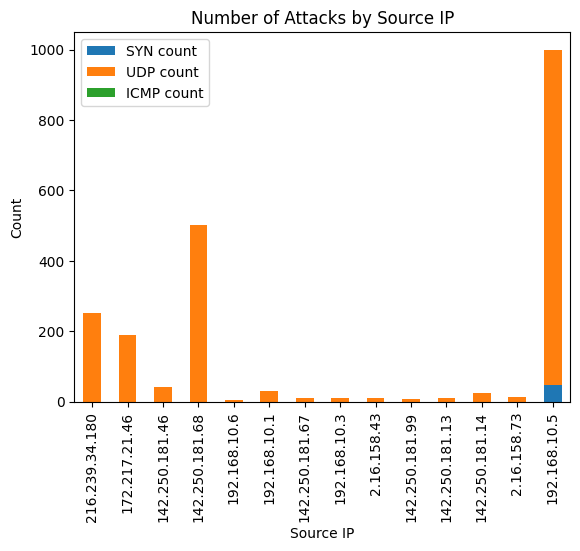

In [11]:

with open('attacks.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Source IP', 'SYN count', 'UDP count', 'ICMP count'])

    for src_ip in syn_counts.keys() | udp_counts.keys() | icmp_counts.keys():
        syn_count = syn_counts.get(src_ip, 0)
        udp_count = udp_counts.get(src_ip, 0)
        icmp_count = icmp_counts.get(src_ip, 0)
        writer.writerow([src_ip, syn_count, udp_count, icmp_count])


# Load the data from the CSV file into a Pandas DataFrame
data = pd.read_csv('attacks.csv')

print(data)
# Create a bar chart
ax = data.plot.bar(x='Source IP', stacked=True)
ax.set_xlabel('Source IP')
ax.set_ylabel('Count')
ax.set_title('Number of Attacks by Source IP')


# **DOS Attacks**

         Source IP   Destination IP Protocol Flags Attack Type
0    192.168.10.13  239.255.255.250                     Normal
1    192.168.10.13      224.0.0.252                     Normal
2    192.168.10.13   52.139.250.209      TCP     A            
3   52.139.250.209    192.168.10.13      TCP     A            
4    192.168.10.13   204.79.197.200      TCP    FA         DoS
5    192.168.10.13     192.168.10.1      UDP            Normal
6    192.168.10.13     192.168.10.1      UDP            Normal
7    192.168.10.13     192.168.10.1      UDP            Normal
8    192.168.10.13     192.168.10.1      UDP            Normal
9     192.168.10.1    192.168.10.13      UDP            Normal
10    192.168.10.1    192.168.10.13      UDP            Normal
11   192.168.10.13     192.168.10.1      UDP            Normal
12    192.168.10.1    192.168.10.13      UDP            Normal
13   192.168.10.13     192.168.10.1      UDP            Normal
14   192.168.10.13     40.79.197.35      TCP     S     

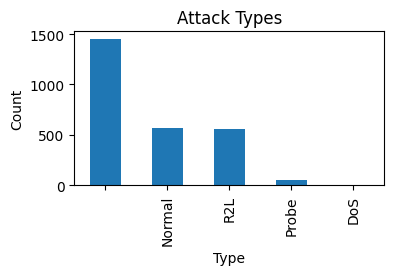

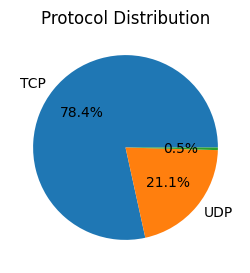

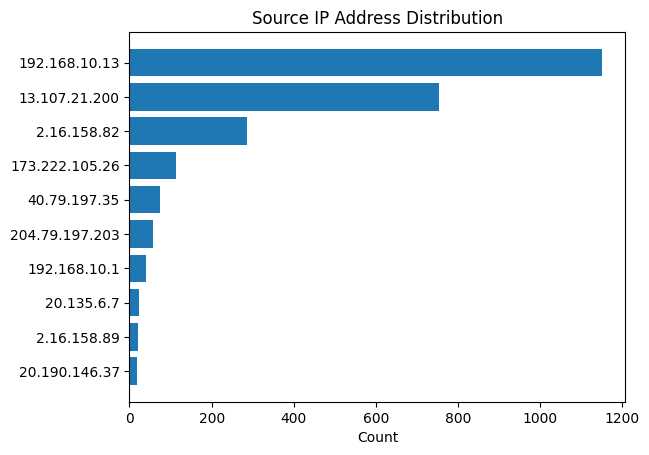

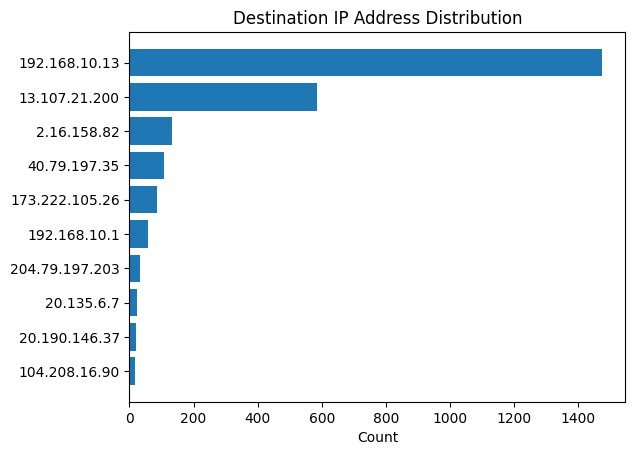

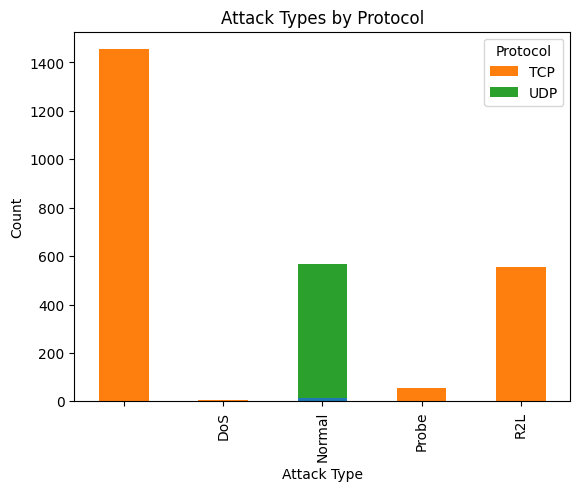

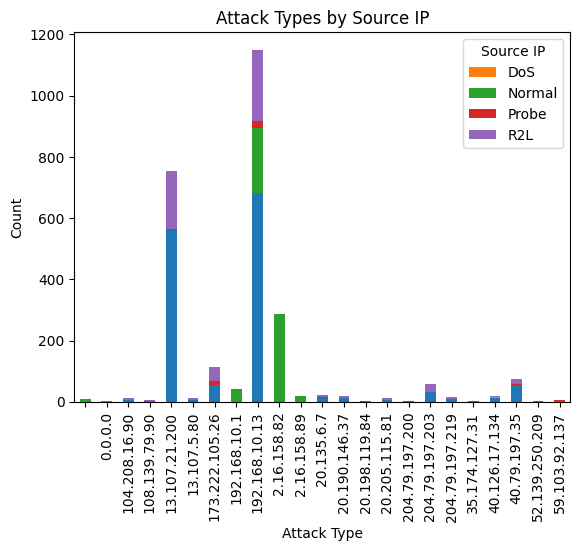

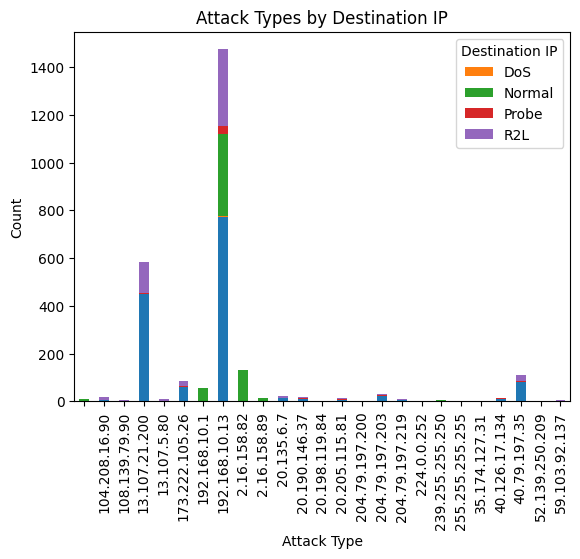

In [12]:

# read the Wireshark file
# packets = rdpcap('wireshark.pcapng')

# create lists to store data
src_ip = []
dst_ip = []
protocol = []
flags = []

# loop through packets and extract necessary data
for packet in packets:
    if IP in packet:
        src_ip.append(packet[IP].src)
        dst_ip.append(packet[IP].dst)
        if TCP in packet:
            protocol.append('TCP')
            flags.append(packet[TCP].flags)
        elif UDP in packet:
            protocol.append('UDP')
            flags.append('')
        else:
            protocol.append('')
            flags.append('')
    else:
        src_ip.append('')
        dst_ip.append('')
        protocol.append('')
        flags.append('')

# create a dataframe with the extracted data
data = pd.DataFrame({'Source IP': src_ip, 'Destination IP': dst_ip, 'Protocol': protocol, 'Flags': flags})

# create a new column with attack types based on flags
data['Attack Type'] = data['Flags'].apply(lambda x: 'Normal' if x == '' else 'DoS' if 'F' in str(x) else 'Probe' if 'S' in str(x) else 'R2L' if 'PA' in str(x) else 'U2R' if 'FRP' in str(x) else '')

# save data to CSV file
data.to_csv('attack_types.csv', index=False)

# show the first few rows of the data
print(data.head(30))
# print(data)
# create a bar graph of the attack types
attack_counts = data['Attack Type'].value_counts()
fig, ax = plt.subplots(figsize=(4, 2))
attack_counts.plot(kind='bar', ax=ax)
# attack_counts.plot(kind='bar')
plt.title('Attack Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

print("\n\n")


# create a pie chart of the protocol distribution
protocol_counts = data['Protocol'].value_counts()
plt.figure(figsize=(3,3))
plt.pie(protocol_counts, labels=protocol_counts.index, autopct='%1.1f%%')
plt.title('Protocol Distribution')
plt.show()

print("\n\n")

# create a horizontal bar chart of the source IP address distribution
src_ip_counts = data['Source IP'].value_counts().nlargest(10)
plt.barh(src_ip_counts.index, src_ip_counts.values)
plt.gca().invert_yaxis()
plt.title('Source IP Address Distribution')
plt.xlabel('Count')
plt.show()

print("\n\n")

# create a horizontal bar chart of the destination IP address distribution
dst_ip_counts = data['Destination IP'].value_counts().nlargest(10)
plt.barh(dst_ip_counts.index, dst_ip_counts.values)
plt.gca().invert_yaxis()
plt.title('Destination IP Address Distribution')
plt.xlabel('Count')
plt.show()


print("\n\n")

#create a stacked bar chart of the attack types by protocol
attack_protocol_counts = data.groupby(['Attack Type', 'Protocol']).size().unstack(fill_value=0)
attack_protocol_counts.plot(kind='bar', stacked=True)
plt.title('Attack Types by Protocol')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.legend(title='Protocol', loc='upper right')
plt.show()

print("\n\n")

#create a stacked bar chart of the attack types by source IP
attack_src_counts = data.groupby(['Attack Type', 'Source IP']).size().unstack(fill_value=0)
attack_src_counts = attack_src_counts.transpose()
attack_src_counts.plot(kind='bar', stacked=True)
plt.title('Attack Types by Source IP')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.legend(title='Source IP', loc='upper right')
plt.show()

print("\n\n")

#create a stacked bar chart of the attack types by destination IP
attack_dst_counts = data.groupby(['Attack Type', 'Destination IP']).size().unstack(fill_value=0)
attack_dst_counts = attack_dst_counts.transpose()
attack_dst_counts.plot(kind='bar', stacked=True)
plt.title('Attack Types by Destination IP')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.legend(title='Destination IP', loc='upper right')
plt.show()



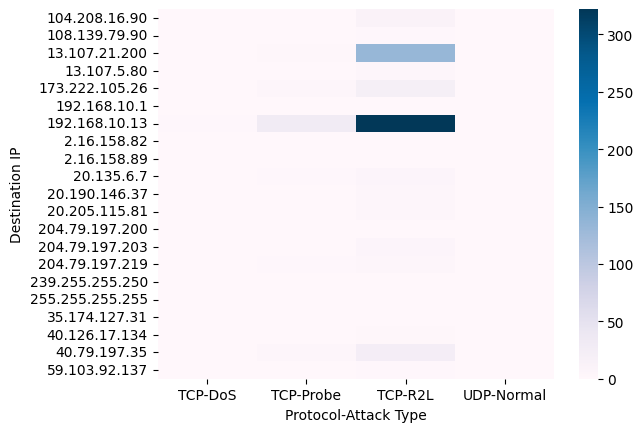

In [13]:

# Load the dataframe from the CSV file
data = pd.read_csv('attack_types.csv')

# Create the heatmap
heatmap_data = pd.pivot_table(data, values='Flags', index='Destination IP', columns=['Protocol', 'Attack Type'], aggfunc='count', fill_value=0)
sns.heatmap(heatmap_data, cmap='PuBu')
# viridis
# YlGnBu
# Show the plot
plt.show()


# **PROTOCOLS**

In [14]:
# Load the PCAP file
# packets = rdpcap('wireshark.pcapng')

# Initialize results list
results = []

# Iterate over each packet in the file
for packet in packets:
    # Check the protocol of the packet
    if packet.haslayer(IP):
        proto = packet[IP].proto

        # Check if the packet is TCP
        if proto == 6 and packet.haslayer(TCP):
            results.append(('TCP', packet[IP].src, packet[TCP].sport, packet[IP].dst, packet[TCP].dport, len(packet[TCP].payload), packet[TCP].seq, packet[TCP].ack))

        # Check if the packet is UDP
        elif proto == 17 and packet.haslayer(UDP):
            results.append(('UDP', packet[IP].src, packet[UDP].sport, packet[IP].dst, packet[UDP].dport, len(packet[UDP].payload), 'N/A', 'N/A'))

        # Check if the packet is ICMP
        elif proto == 1 and packet.haslayer(ICMP):
            results.append(('ICMP', packet[IP].src, 'N/A', packet[IP].dst, 'N/A', len(packet[ICMP].payload), packet[ICMP].seq, packet[ICMP].ack))

        # Check if the packet is QUIC
        elif proto == 208 and packet.haslayer(QUIC):
            results.append(('QUIC', packet[IP].src, packet[QUIC].sport, packet[IP].dst, packet[QUIC].dport, len(packet[QUIC].payload), packet[QUIC].header.packet_number, 'N/A'))

        # Check if the packet is ARP
        elif proto == 1 and packet.haslayer(ARP):
            results.append(('ARP', packet[IP].src, 'N/A', packet[IP].dst, 'N/A', len(packet[ARP].payload), 'N/A', 'N/A'))

        # Check if the packet is TLSv1.2
        elif proto == 132 and packet.haslayer(TLS):
            results.append(('TLSv1.2', packet[IP].src, packet[TLS].sport, packet[IP].dst, packet[TLS].dport, len(packet[TLS].payload), packet[TLS].seq, packet[TLS].ack))

# Create a Pandas dataframe from the results
df = pd.DataFrame(results, columns=['Protocol', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Length', 'Sequence Number', 'ACK Number'])

# df.columns
# Save the dataframe to an Excel file
df.to_csv('wireshark_analysis.csv', index=False)

print(df)

# Print the first 10 rows of the dataframe
# print(df.head(30))


     Protocol       Source IP  Source Port  Destination IP  Destination Port  \
0         TCP   192.168.10.13        64845  52.139.250.209               443   
1         TCP  52.139.250.209          443   192.168.10.13             64845   
2         TCP   192.168.10.13        64868  204.79.197.200               443   
3         UDP   192.168.10.13        65248    192.168.10.1                53   
4         UDP   192.168.10.13        62085    192.168.10.1                53   
...       ...             ...          ...             ...               ...   
2618      TCP   192.168.10.13        64895   13.107.21.200               443   
2619      TCP   192.168.10.13        64850   35.174.127.31               443   
2620      TCP   35.174.127.31          443   192.168.10.13             64850   
2621      TCP   192.168.10.13        64850   35.174.127.31               443   
2622      TCP   35.174.127.31          443   192.168.10.13             64850   

      Length Sequence Number  ACK Numbe

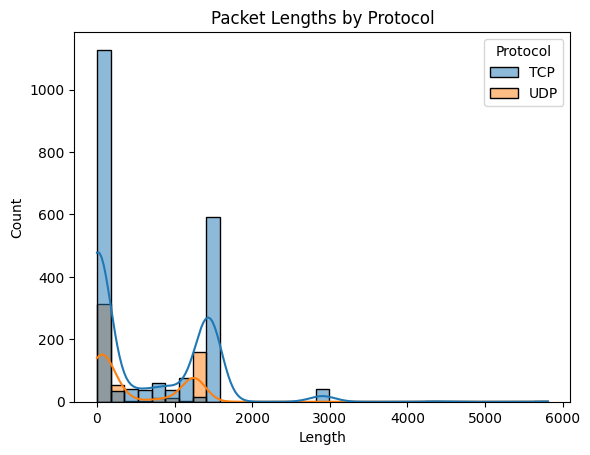

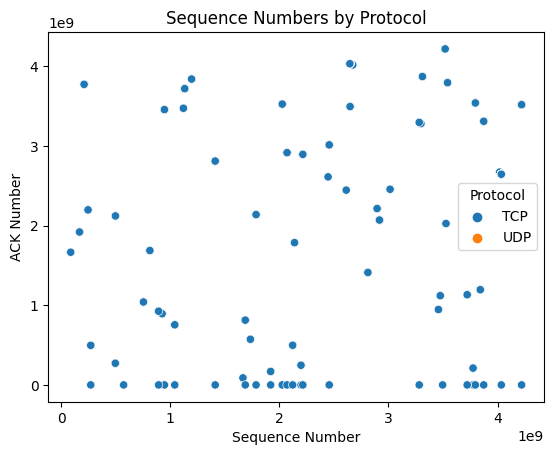

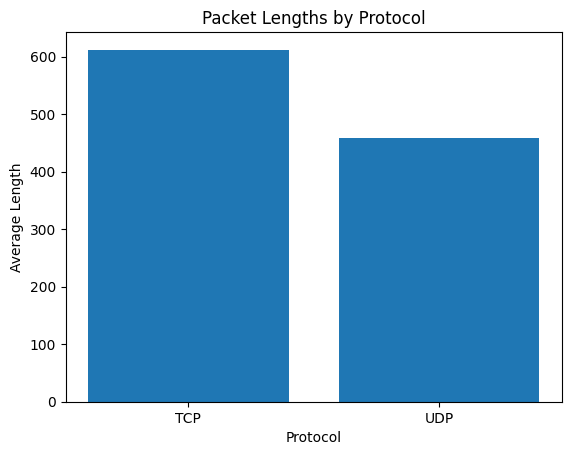

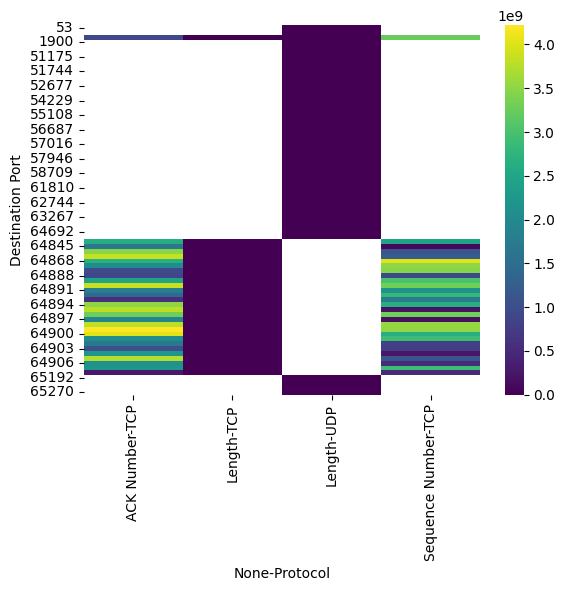

In [15]:

# Load the data from the CSV file
df = pd.read_csv('wireshark_analysis.csv')

# Print the summary statistics of the numerical columns
# print(df.describe())

# Generate a histogram of packet lengths by protocol
sns.histplot(data=df, x='Length', hue='Protocol', kde=True)
plt.title('Packet Lengths by Protocol')
plt.savefig('hist_packet_lengths.png')
plt.show()

print("\n\n")

# Generate a scatter plot of sequence numbers by protocol
sns.scatterplot(data=df, x='Sequence Number', y='ACK Number', hue='Protocol')
plt.title('Sequence Numbers by Protocol')
plt.savefig('sequence_numbers.png')
plt.show()

print("\n\n")


# Group the packets by their protocol and calculate the average length for each protocol
protocol_lengths = df.groupby('Protocol')['Length'].mean()

# Create a bar chart of the protocol lengths
plt.bar(protocol_lengths.index, protocol_lengths)
plt.xlabel('Protocol')
plt.ylabel('Average Length')
plt.title('Packet Lengths by Protocol')
plt.savefig('bar_packet_lengths.png')
plt.show()

# Create the heatmap
heatmap_data = pd.pivot_table(df, values=['Length', 'Sequence Number', 'ACK Number'], index='Destination Port', columns='Protocol')
sns.heatmap(heatmap_data, cmap='viridis')
plt.show()



# Testing and Validation: whether the system is detecting and alerting on potential threats accurately

In [16]:
# Load the Wireshark file
packets = rdpcap('testing_file.pcapng')

ssh_alerts = []
arp_alerts = []

# Develop and implement a rule to detect brute force attacks against SSH
def detect_ssh_brute_force(packet):
    if packet.haslayer(TCP) and packet.haslayer(Raw):
        if packet[TCP].dport == 22 and "Failed" in str(packet[Raw]):
            ssh_alerts.append(packet)
            print("SSH Brute Force Attack Detected: ", packet.summary())
            # response mechanism 
            send_email()
            block_ip(packet[IP].src)

# Develop and implement a rule to detect ARP spoofing
def detect_arp_spoofing(packet):
    if packet.haslayer(ARP):
        if packet[ARP].op == 2:
            mac = packet[ARP].hwsrc
            ip = packet[ARP].psrc
            if mac != packet[ARP].hwdst:
                arp_alerts.append(packet)
                print("ARP Spoofing Detected: MAC", mac, "is trying to use IP", ip)
                # response mechanism 
                send_email()
                block_ip(ip)

# Apply the rules to each packet in the file
for packet in packets:
    detect_ssh_brute_force(packet)
    detect_arp_spoofing(packet)

# Validate the system
if len(ssh_alerts) == 0 and len(arp_alerts) == 0:
    print("System needs tuning")
else:
    print("Testing Successfully")


ARP Spoofing Detected: MAC 5c:3a:45:8a:9f:d5 is trying to use IP 192.168.10.13
Email sent to mukandrathi112@gmail.com
*********________Error blocking IP address 192.168.10.13
Testing Successfully
